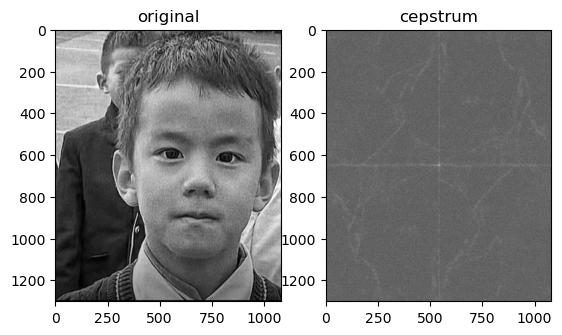

In [1]:
import math
import math

import cv2
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


# 模糊核生成
def get_motion_dsf(image_size, motion_dis, motion_angle):
    PSF = np.zeros(image_size)  # 点扩散函数
    x_center = (image_size[0] - 1) / 2
    y_center = (image_size[1] - 1) / 2

    sin_val = math.sin(motion_angle * math.pi / 180)
    cos_val = math.cos(motion_angle * math.pi / 180)

    # 将对应角度上motion_dis个点置成1
    for i in range(motion_dis):
        x_offset = round(sin_val * i)
        y_offset = round(cos_val * i)
        PSF[int(x_center - x_offset), int(y_center + y_offset)] = 1

    return np.fft.fft2(PSF / PSF.sum())

# 维纳滤波
def wiener(f, PSF,K=0.01):  # 维纳滤波，K=0.01
    input_fft = np.fft.fft2(f)
    PSF_fft_1 = np.conj(PSF) / (np.abs(PSF) ** 2 + K)
    result = np.fft.ifftshift(np.fft.ifft2(input_fft * PSF_fft_1))
    return result.real


def show(f, s, a, b, c):
    plt.subplot(a, b, c)
    plt.imshow(f, "gray")
    plt.axis('on')
    plt.title(s)


def main():
    f = plt.imread("F:\\tuxiNG.jpg")
    f = cv.cvtColor(f, cv.COLOR_RGB2GRAY)
    # 生成倒谱图
    ft = np.fft.fft2(f)
    ift = np.fft.fftshift(np.abs(np.fft.fft2(np.log(ft + 1e-3))))
    logF = np.log(ift + 1e-3)

    plt.figure()
    show(f, "original", 1, 2, 1)
    show(logF, "cepstrum", 1, 2, 2)
    plt.show()

    line = cv.HoughLinesP(ift.astype(np.uint8), 1, np.pi / 180, 20, 0, 25, 0)
    l = []
    for i in range(len(line)):
        r = np.power((line[i][0][2] - line[i][0][0]) ** 2 + (line[i][0][3] - line[i][0][1]) ** 2, 0.5)
        theta = math.atan2(line[i][0][3] - line[i][0][1], line[i][0][2] - line[i][0][0]) / math.pi * 180.
        if 20 < r < 50 and 30 < theta < 60:
            l.append((r, -theta))

    # 使用局部光滑区域拉普拉斯变换确定最优运动模糊核长度和角度
    vars = []
    kernel = np.array([0, -1, 0, -1, 4, -1, 0, -1, 0]).reshape(3, 3)
    for k in l:
        r, theta = k
        PSF = get_motion_dsf(f.shape, int(r), int(theta))
        rf = wiener(f, PSF)
        temp = rf[425:450, 325:350]
        for i in range(1, temp.shape[0] - 1):
            for j in range(1, temp.shape[1] - 1):
                temp[i, j] = np.abs(np.sum(temp[i - 1:i + 2, j - 1:j + 2] * kernel))
        vars.append(np.sum(temp))
    r, theta = l[vars.index(min(vars))]
    print(r)
    print(theta)

    PSF = get_motion_dsf(f.shape, int(r), int(theta))
    plt.figure()
    show(f, "f", 1, 2, 1)
    show(wiener(f, PSF), "restoreImage", 1, 2, 2)
    plt.show()


if __name__ == '__main__':
    main()
